# Togetherflow
**Emergent agent motion dynamics in immersive rooms**

In this notebook, we implement Togetherflow, a computational cognitive model that characterizes the motion pattern of human agents in immersive rooms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numba import njit
from functools import partial

np.set_printoptions(suppress=True)

In [3]:
import tensorflow as tf
import bayesflow as bf
from bayesflow.simulation import Prior, Simulator, GenerativeModel

## Generative Model Definition

The movement of any agent $a = 1, ..., A$ is both related to: 1) its interaction with surrounding neighbors $i = 1, ..., I$, which we call *internal influence*, and 2) their motivation to the surrounding spatial objects $b = 1, ..., B$, which we call *external influence*. These influences are modulated by a stationary weight, $w_a$:

\begin{equation}
    \theta_{a, t} = w_a \theta_{a|j, t} + (1 - w_a) \theta_{a|i, t}.
\end{equation}

### Meta-Variables

First, we define some meta-variables, such as the number of agents to simulate, the number of spatial beacons present in the environment, etc.

In [4]:
num_agents = 12
num_beacons = 2
room_size = (8., 10.)
world_size = 25.

### Agent Initialization

First, we initialize the agents with a randomized position and orientation, both uniformly distributed.

In [5]:
@njit
def initialize_agents(
    num_agents: int = 12, 
    room_size: tuple = (8., 10.),
):
    """
    Generate random positions and orientations for agents.

    Parameters
    ----------
    num_agents : int, optional
        Number of agents to generate (default is 100).
    room_size : float, optional
        The size of the boundary within which positions are generated (default is 100.0).

    Returns
    -------
    tuple of np.ndarray
        A tuple containing the positions (np.ndarray) and orientations (np.ndarray) of the agents.
    """
    
    # Generate random positions within the boundary size centered at 0
    x = (np.random.random(size=num_agents).astype(np.float32) - 0.5) * room_size[0]
    y = (np.random.random(size=num_agents).astype(np.float32) - 0.5) * room_size[1]
    positions = np.vstack((x, y)).T
    
    # Generate random orientations (angles in radians between 0 and 2*pi)
    rotations = np.random.random(size=(num_agents, )).astype(np.float32) * np.pi * 2
    
    return positions.astype(np.float32), rotations.astype(np.float32)

In [6]:
agent_positions, agent_rotations = initialize_agents(room_size=room_size, num_agents=12)
agent_positions

array([[-3.9790418 ,  0.65818787],
       [ 0.6976805 , -3.2577343 ],
       [-1.3726492 , -1.3447883 ],
       [-0.3578384 ,  3.5467558 ],
       [ 1.0047183 , -4.2603836 ],
       [-3.149682  , -1.0367534 ],
       [-0.46131992, -3.9603655 ],
       [-1.3981786 , -3.4038131 ],
       [-2.4595451 , -3.2489595 ],
       [ 3.7529092 ,  2.2679453 ],
       [ 1.680995  ,  1.6806    ],
       [-0.14678931,  4.0904465 ]], dtype=float32)

### Beacon initialization

To intrinsically motivate the agents, we need a set of virtual beacons that are populated within the environment. The beacons have a freer representation with only positions needed.

In [7]:
@njit
def initialize_beacons(
        num_beacons = 10,
        room_sensing_range = 50.
):
    
    """
    Initialize beacons following a uniform distribution scaled to the room's sensing boundary
    
    Parameters
    ----------
    num_beacons : int, default: 10
        Number of beacons to initialize.
    room_sensing_range : float, default: 50.0
        Sensing distance of the room for the beacons to matter.
    
    Returns 
    -------
    beacons      : np.ndarray of shape (num_beacons, 2)
        Initial positions of the beacons. 
    """
    
    beacons = (np.random.random(size=(num_beacons, 2)) - 0.5) * room_sensing_range
    return beacons.astype(np.float32)

In [8]:
beacon_positions = initialize_beacons(num_beacons=1, room_sensing_range=world_size)
beacon_positions

array([[8.519482 , 5.1483483]], dtype=float32)

## External Influence: drift-diffusion vector

We want to compute the influence of agent movement direction within a single time step. For this, we specify our internal influence as a 2D drift diffusion model, where the agents are approach a spatial beacon within the room's boundary by reorienting its locomotive direction.

\begin{equation}
    \theta_{a|j, t} = \theta_{a|j, t-1} + \omega_a \mathrm{d}t + \mathrm{d}\phi_t,
\end{equation}

\begin{align}
    \mathrm{d}\mathbf{x}_{a|j, t} 
    &= v_{a|j}\mathrm{d}t \frac{\mathbf{x}_{a|j}}{||\mathbf{x}_{a|j}||} + \sigma_{a|j} \mathrm{d}\mathrm{W}_t \\
    &= v_{a}\mathrm{d}t     
    \begin{bmatrix}
        \cos \theta_{a|j, t} \\
        \sin \theta_{a|j, t}
    \end{bmatrix} + \sigma_{a|j} \mathrm{d}\mathrm{W}_t,% \sqrt{\mathrm{d}t} Z_t.
\end{align}

In [9]:
@njit
def external_influence( 
    agent_position,
    beacon_position,
    noise = False,
    noise_amplitude = 0.01
):
    """
    Generate a drift-diffusion vector in 2D space for a single agent 
    based on a target location (in this case, the position of a beacon).

    Parameters
    ----------
    agent_position : np.ndarray
        The position of the agent.
    target_position : np.ndarray
        The position of the target beacon.
    focus : float, optional
        The dispersion of a von Mises distribution for rotational noise influenced by the neighbors.
        The higher the value is, the less perturbation there would be.
    noise: bool, optional
        Whether the focus is interpreted as noise amplitude.

    Returns
    -------
    np.ndarray
        A 2D vector representing the drift-diffusion process towards the target (beacon).
    """
    # Calculate the angle towards the beacon (in radian)
    beacon_direction = np.arctan2(
        beacon_position[1] - agent_position[1], 
        beacon_position[0] - agent_position[0]
    )
    
    # Generate a random direction with drift around the target angle
    if noise:
        beacon_direction = beacon_direction + (np.random.random() - 0.5) * noise_amplitude
        # beacon_direction = beacon_direction + np.random.vonmises(0., 8.) * noise_amplitude
    
    # Convert the angle to a unit vector in 2D space
    v = np.array([np.cos(beacon_direction), np.sin(beacon_direction)], dtype=np.float32)
    
    return v

## Internal Influence: particle dynamics

Its influence by a collective group of agents is modeled as a self-propelling particle system, as expressed in the Vicsek model:

\begin{align}
    \theta_{a|i, t} &= \langle \theta_{i, t}\rangle_{|\mathbf{x}_a - \mathbf{x}_i| < r_a, i \in I} + \eta_{a,t-1}, \\
    \mathrm{d} \mathbf{x}_{a|i,t} &= v_{a,t} \mathrm{d}t
    \begin{bmatrix}
        \cos \theta_{a|i, t} \\
        \sin \theta_{a|i, t}
    \end{bmatrix},
\end{align}

In [10]:
@njit 
def internal_influence(
        self_position,
        other_positions,
        other_rotations,
        sensing_radius = 1.5,
        focus = 0.125,
        noise = False
):
    """
    Generate an influence vector for a single agent 
    based on the angular component of the Vicsek model.

    Parameters
    ----------
    self_position : np.ndarray of shape (2,)
        A 2D vector representing the position of the agent
    other_positions : np.ndarray of shape (2,)
        A 2D vector representing the positions of the neighboring agents.
    other_rotations : np.ndarray of shape (2,)
        A 2D vector representing the rotations of the neighboring agents.
    sensing_radius : float
        The sensing radius within which agents interact with their neighbors.
    focus : float, optional
        The dispersion of a von Mises distribution for rotational noise influenced by the neighbors.
        The higher the value is, the less perturbation there would be.
    noise: bool, optional
        Whether the focus is interpreted as noise amplitude.

    Returns
    -------
    np.ndarray
        A 2D unit vector representing the averaged influence direction with added noise.
    """
      
    neighbor_rotations = []
    
    for i in range(len(other_positions)):
        dx = other_positions[i, 0] - self_position[0]
        dy = other_positions[i, 1] - self_position[1]
        d = (dx ** 2 + dy ** 2) ** 0.5
        
        if d <= sensing_radius and d > 0:
            neighbor_rotations.append(other_rotations[i])
            
    if len(neighbor_rotations) == 0:
        return np.array([0.0, 0.0], dtype=np.float32)
    
    neighbor_rotations = np.array(neighbor_rotations)
    averaged_rotation = np.sum(neighbor_rotations) / len(neighbor_rotations)
    
    if noise:
        deviation = (np.random.random() - 0.5) * focus
    else:
        deviation = np.random.vonmises(mu=0., kappa=4.) * focus
    direction = averaged_rotation + deviation
    
    v = np.array([np.cos(direction), np.sin(direction)], dtype=np.float32) 
    
    return v

## Putting everything together: combined influences

The combined influences allow us to update the agents' positions and rotations together.

In [11]:
@njit
def combined_influences(
    agent_positions: np.ndarray = None, 
    agent_rotations: np.ndarray = None,
    beacon_positions: np.ndarray = None,
    velocity: float = 1.0, 
    sensing_radius: float = 2.5,
    dt: float = 0.1, 
    influence_weight: float = 0.5,
    #external_noise: float = 8.,
    internal_focus: float = 8.
):
    """
    Update the positions and orientations of a single agent 
    based on velocity and influence vectors.

    Parameters
    ----------
    agent_positions : np.ndarray
        Current positions of the agents.
    agent_rotations : np.ndarray
        Current orientations of the agents.
    beacon_positions : np.ndarray
        Positions of the beacons.
    velocity : float, optional
        The speed at which agents move (default is 1.0).
    sensing_radius : float, optional
        The sensing radius within which agents interact with their neighbors.
    dt : float, optional
        The time step for updating positions and orientations (default is 0.1).
    influence_weight : float, optional
        The weight of influence_vector1 in determining new orientations (default is 0.7).
    external_focus : float, optional
        Concentration of the agent's rotational noise influenced by the beacons
    internal_focus : float, optional
        Concentration of the agent's rotational noise influenced by the neighbors

    Returns
    -------
    tuple of np.ndarray
        Updated positions (np.ndarray) and orientations (np.ndarray) of the agents.
    """
    
    assert (len(agent_positions) == len(agent_rotations))
    
    num_agents = agent_positions.shape[0]
    num_beacons = beacon_positions.shape[0]
    
    # Create new numpy arrays for the updated agent positions and rotations
    new_agent_positions = np.zeros((num_agents, 2))
    new_agent_rotations = np.zeros((num_agents, ))
    
    for i in range(num_agents):
        # Generate the ddm vector for the agent based on its closest beacon
        distance_to_beacon = []
        
        for b in range(num_beacons):
            bx = beacon_positions[b, 0] - agent_positions[i, 0]
            by = beacon_positions[b, 1] - agent_positions[i, 1]
            distance_to_beacon.append((bx * bx + by * by) ** 0.5)
        
        beacon_id = np.argmin(np.array(distance_to_beacon))
        
        ddm_vector = external_influence(
            agent_positions[i], 
            beacon_positions[beacon_id],
            #focus=external_focus
        )
        
        # Generate the vicsek vector for the agent based on its neighbors (all agents)
        vicsek_vector = internal_influence(
            self_position=agent_positions[i],
            other_positions=agent_positions,
            other_rotations=agent_rotations,
            sensing_radius=sensing_radius,
            focus=internal_focus
        )

        # Update orientations based on two influence vectors
        ddm_influence = np.arctan2(ddm_vector[1], ddm_vector[0])
        vicsek_influence = np.arctan2(vicsek_vector[1], vicsek_vector[0])
        
        # Combine influences to update orientations with different weights
        new_agent_rotations[i] = agent_rotations[i] + (influence_weight * ddm_influence + (1 - influence_weight) * vicsek_influence) * dt
        
        # Ensure orientations are within the range [0, 2*pi]
        new_agent_rotations[i] = np.mod(new_agent_rotations[i], 2 * np.pi)
        
        # Update positions based on current orientations
        new_agent_positions[i, 0] = agent_positions[i, 0] + velocity * np.cos(new_agent_rotations[i].item()) * dt
        new_agent_positions[i, 1] = agent_positions[i, 1] + velocity * np.sin(new_agent_rotations[i].item()) * dt
    
    return new_agent_positions, new_agent_rotations

In [12]:
agent_positions, agent_rotations = initialize_agents(12, room_size=room_size)
beacon_positions = initialize_beacons(num_beacons=2)
new_agent_positions, new_agent_rotations = combined_influences(agent_positions, agent_rotations, beacon_positions)

In [13]:
np.concatenate([agent_positions, new_agent_positions], axis=1)

array([[ 0.51325369,  3.01931334,  0.41572802,  2.99720578],
       [-3.35083842, -2.43476677, -3.45081859, -2.43675826],
       [ 0.09853888,  0.45403004,  0.14848545,  0.36739667],
       [ 0.01498175, -3.97918272,  0.11030343, -3.94895397],
       [-2.96583796, -4.54804564, -3.06522147, -4.53695886],
       [ 1.82053089,  1.77035749,  1.85069113,  1.67501411],
       [-2.54688692, -0.76227099, -2.4703982 , -0.82668741],
       [ 2.82082605,  4.85186529,  2.7432577 ,  4.78875309],
       [ 2.74105215,  0.48033774,  2.83969197,  0.49677505],
       [ 2.59929419, -1.56056976,  2.69910791, -1.55446894],
       [ 0.96764755,  0.05384684,  0.88426484, -0.00135574],
       [ 3.0305748 ,  1.71229959,  3.07774623,  1.80047473]])

In [14]:
np.vstack([agent_rotations, new_agent_rotations]).T

array([[3.34374332, 3.36450984],
       [3.2537396 , 3.16150886],
       [5.36891365, 5.23537092],
       [0.30081761, 0.30709147],
       [2.91522503, 3.03049649],
       [5.05965757, 5.01876184],
       [5.56141663, 5.58325523],
       [3.77095962, 3.82459157],
       [0.36333835, 0.16512249],
       [0.15549062, 0.06104611],
       [3.69033122, 3.72638436],
       [1.09726059, 1.07956229]])

## Simulation Loop

The update allows us to continuously simulate the agents' positions and rotations at a given interval

In [15]:
@njit
def simulator_fun(
    theta = None,
    num_agents: int = 12, 
    num_beacons: int = 1,
    room_size: tuple = (8, 10),
    velocity: float = 1.0, 
    dt: float = 0.1, 
    influence_weight: float = 0.7, 
    sensing_radius: float = 10.0,
    internal_focus: float = 8.,
    #external_focus: float = 8.,
    num_timesteps: int = 1000
):
    """
    Run the simulation and store the time series of positions and orientations of agents.

    Parameters
    ----------
    theta : np.ndarray
        Prior parameters specifying the internal properties of the agents
    num_agents : int, optional
        Number of agents to generate (default is 100).
    num_beacons : int, optional
        Number of beacons to generate (default is 1).
    room_size : float, optional
        The size of the boundary within which positions are generated (default is 100).
    velocity : float, optional
        The speed at which agents move (default is 1.0).
    dt : float, optional
        The time step for the update (default is 0.1).
    influence_weight : float, optional
        The weight for influence_vector1 in determining new orientations (default is 0.7).
    sensing_radius : float, optional
        The sensing radius for the Vicsek model (default is 10.0).
    num_timesteps : int, optional
        The number of steps to simulate (default is 100).

    Returns
    -------
    tuple of np.ndarray
        The time series of positions and orientations of the agents.
    """
    
    if theta is not None:
        influence_weight = theta[0]
        sensing_radius = theta[1]
        velocity = theta[2]
        #external_focus = theta[3]
        #internal_focus = theta[4]
    
    
    # Initialize positions and orientations
    initial_positions, initial_rotations = initialize_agents(num_agents, room_size=room_size)

    # Initialize arrays to store time series of positions and orientations
    positions = np.zeros((num_timesteps, num_agents, 2))
    rotations = np.zeros((num_timesteps, num_agents, ))
    positions[0] = initial_positions
    rotations[0] = initial_rotations
    
    # Initialize beacons
    beacon_positions = initialize_beacons(num_beacons)

    # Simulation loop
    for t in range(1, num_timesteps):
        ps, rs = combined_influences(
            agent_positions=positions[t-1], 
            agent_rotations=rotations[t-1], 
            beacon_positions=beacon_positions, 
            velocity=velocity, 
            sensing_radius=sensing_radius, 
            dt=dt, 
            influence_weight=influence_weight,
            #external_focus=external_focus,
            internal_focus=internal_focus
        )
        
        # Store positions and orientations for each time step
        positions[t] = ps
        rotations[t] = rs
    
    rotations = rotations[:,:,np.newaxis]

    return np.concatenate((positions, rotations), axis=-1)

# Complete pooling priors

In [16]:
param_names = [
    r"$w$",
    r"$r$",
    r"$v$",
    # r"$\eta$",
    # r"$\kappa$"
]

In [17]:
@njit
def prior_fun():
    weight = np.random.beta(2, 2)
    radius = np.random.beta(2, 2) * 5.
    v = np.random.beta(2, 2) * 2.
    return np.array([weight, radius, v])

In [18]:
theta = prior_fun()
theta

array([0.76120608, 3.41515756, 1.4648371 ])

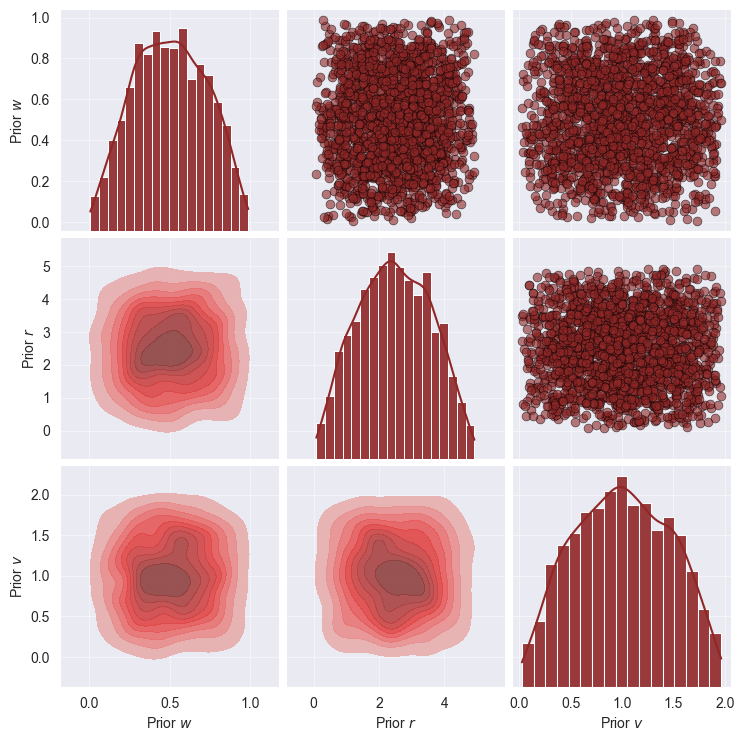

In [21]:
prior = Prior(prior_fun=prior_fun, param_names=param_names)
pp_check = prior.plot_prior2d()

# Generative Model

In [22]:
simulator = Simulator(simulator_fun=partial(simulator_fun, num_timesteps=1001))
simulator

In [23]:
model = GenerativeModel(
    prior=prior,
    simulator=simulator,
    simulator_is_batched=False,
    name="TogetherFlow"
)

INFO:root:Performing 2 pilot runs with the TogetherFlow model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1001, 12, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


### Prior Pushforward Check

In [24]:
out = model(1)
out['sim_data'][0,:,0].shape

(1001, 3)

# Configurator

In [25]:
def configurator(input_dict: dict = None, transpose: bool = True):
    
    output_dict = {}
    output_dict['parameters'] = input_dict['prior_draws'].astype(np.float32)
    x = input_dict['sim_data'] / 10. 
    if transpose:
        x = np.transpose(x, (0, 2, 1, 3))
    output_dict['summary_conditions'] = x.astype(np.float32)
    return output_dict

# Neural Approximator

In [26]:
# This one generalizes over different numbers of agents
summary_net = bf.summary_networks.HierarchicalNetwork([
    tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(units=128)),
    bf.networks.SetTransformer(num_inducing_points=None, input_dim=128, summary_dim=64)
])

inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=3, 
    num_coupling_layers=6,
    coupling_design="affine",
    coupling_settings={
        'kernel_regularizer': None,
        'dropout_prob': 0.0
    }
)

amortizer = bf.amortizers.AmortizedPosterior(
    summary_net=summary_net, 
    inference_net=inference_net
)

# Training

In [27]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configurator
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


### Offline Training

Skip this part.

In [26]:
training_set = model(10000)

KeyboardInterrupt: 

In [124]:
h = trainer.train_offline(training_set, epochs=100, batch_size=100, validation_sims=model(200))

Training epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 1.525


Training epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 1.442


Training epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 1.353


Training epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 1.219


Training epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 1.150


Training epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 1.027


Training epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 1.011


Training epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: 1.039


Training epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: 0.934


Training epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: 1.291


Training epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Loss: 1.339


Training epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Loss: 1.574


Training epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Loss: 1.216


Training epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Loss: 1.080


Training epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Loss: 1.033


Training epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Loss: 0.994


Training epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Loss: 0.991


Training epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Loss: 0.918


Training epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Loss: 1.052


Training epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Loss: 0.920


Training epoch 21:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Loss: 0.982


Training epoch 22:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Loss: 0.921


Training epoch 23:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Loss: 0.828


Training epoch 24:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Loss: 0.542


Training epoch 25:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Loss: 0.334


Training epoch 26:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Loss: 0.800


Training epoch 27:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Loss: 0.372


Training epoch 28:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Loss: 1.119


Training epoch 29:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Loss: 1.011


Training epoch 30:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Loss: 0.278


Training epoch 31:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, Loss: 0.212


Training epoch 32:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, Loss: -0.058


Training epoch 33:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, Loss: -0.040


Training epoch 34:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, Loss: 0.252


Training epoch 35:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, Loss: -0.327


Training epoch 36:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, Loss: -0.434


Training epoch 37:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, Loss: -0.352


Training epoch 38:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, Loss: -0.523


Training epoch 39:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, Loss: -0.652


Training epoch 40:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, Loss: -0.823


Training epoch 41:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, Loss: -0.865


Training epoch 42:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, Loss: -0.679


Training epoch 43:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, Loss: -0.784


Training epoch 44:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, Loss: -0.509


Training epoch 45:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, Loss: -0.586


Training epoch 46:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, Loss: -0.873


Training epoch 47:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, Loss: -0.760


Training epoch 48:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, Loss: -0.656


Training epoch 49:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, Loss: -0.989


Training epoch 50:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, Loss: -0.834


Training epoch 51:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 51, Loss: -0.824


Training epoch 52:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 52, Loss: -0.919


Training epoch 53:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 53, Loss: -0.618


Training epoch 54:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 54, Loss: -1.029


Training epoch 55:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 55, Loss: -1.070


Training epoch 56:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 56, Loss: -0.894


Training epoch 57:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 57, Loss: -1.235


Training epoch 58:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 58, Loss: -1.178


Training epoch 59:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 59, Loss: -0.875


Training epoch 60:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 60, Loss: -1.131


Training epoch 61:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 61, Loss: -1.319


Training epoch 62:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 62, Loss: -1.085


Training epoch 63:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 63, Loss: -1.418


Training epoch 64:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 64, Loss: -1.380


Training epoch 65:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 65, Loss: -1.324


Training epoch 66:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 66, Loss: -1.355


Training epoch 67:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 67, Loss: -1.310


Training epoch 68:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 68, Loss: -1.372


Training epoch 69:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 69, Loss: -1.475


Training epoch 70:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 70, Loss: -1.441


Training epoch 71:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 71, Loss: -1.448


Training epoch 72:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 72, Loss: -1.346


Training epoch 73:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 73, Loss: -1.327


Training epoch 74:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 74, Loss: -1.413


Training epoch 75:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 75, Loss: -1.501


Training epoch 76:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 76, Loss: -1.314


Training epoch 77:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 77, Loss: -1.430


Training epoch 78:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 78, Loss: -1.458


Training epoch 79:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 79, Loss: -1.540


Training epoch 80:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 80, Loss: -1.610


Training epoch 81:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 81, Loss: -1.600


Training epoch 82:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 82, Loss: -1.609


Training epoch 83:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 83, Loss: -1.635


Training epoch 84:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 84, Loss: -1.657


Training epoch 85:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 85, Loss: -1.645


Training epoch 86:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 86, Loss: -1.576


Training epoch 87:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 87, Loss: -1.609


Training epoch 88:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 88, Loss: -1.650


Training epoch 89:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 89, Loss: -1.579


Training epoch 90:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 90, Loss: -1.649


Training epoch 91:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 91, Loss: -1.639


Training epoch 92:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 92, Loss: -1.646


Training epoch 93:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 93, Loss: -1.632


Training epoch 94:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 94, Loss: -1.647


Training epoch 95:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 95, Loss: -1.641


Training epoch 96:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 96, Loss: -1.644


Training epoch 97:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 97, Loss: -1.628


Training epoch 98:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 98, Loss: -1.631


Training epoch 99:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 99, Loss: -1.625


Training epoch 100:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 100, Loss: -1.623


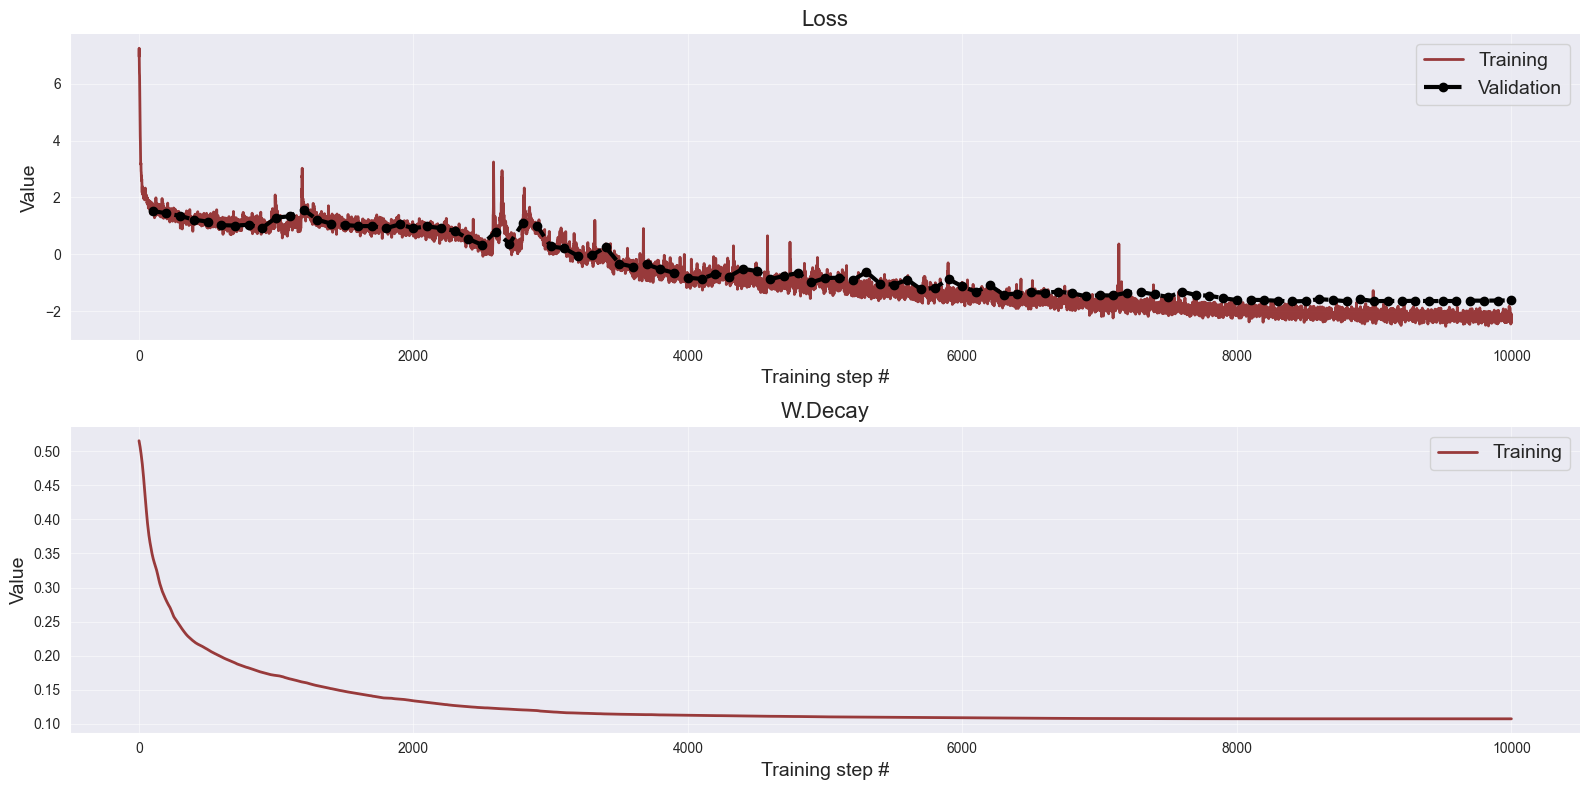

In [125]:
losses = bf.diagnostics.plot_losses(train_losses=h['train_losses'], val_losses=h['val_losses'])

In [126]:
val_sims = configurator(model(400))
post_dev_samples = amortizer.sample(val_sims, n_samples=500)
prior_dev_samples = val_sims['parameters']

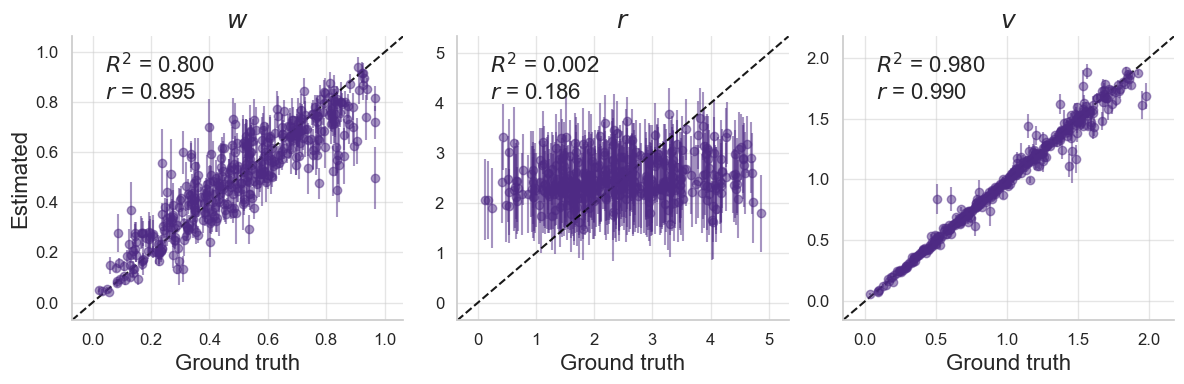

In [127]:
sns.set(rc={'axes.facecolor':'#FFFFFF00', 'figure.facecolor':'#FFFFFF00'})
sns.set_style('whitegrid')

g = bf.diagnostics.plot_recovery(
    post_samples=post_dev_samples, 
    prior_samples=prior_dev_samples, 
    param_names=param_names,
    color="#4E2A84"
)

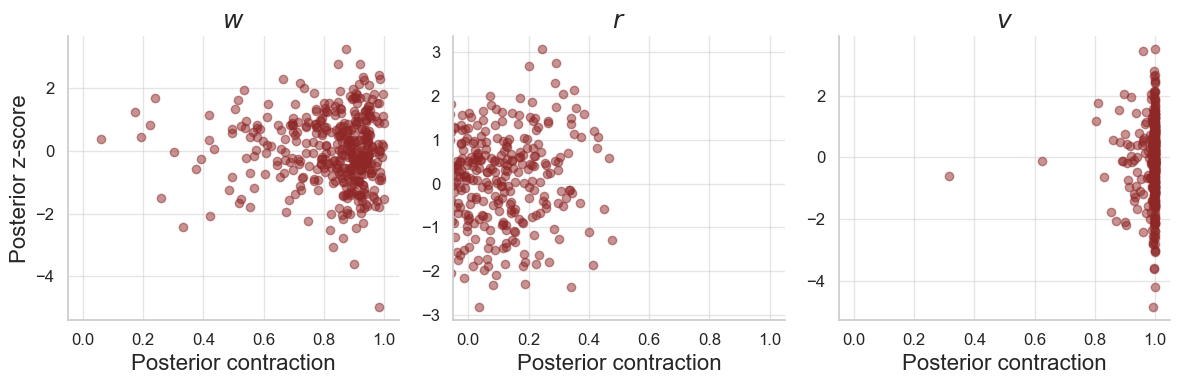

In [128]:
c = bf.diagnostics.plot_z_score_contraction(
    post_samples=post_dev_samples, 
    prior_samples=prior_dev_samples, 
    param_names=param_names
)

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 0.                    Confidence intervals might be unreliable!


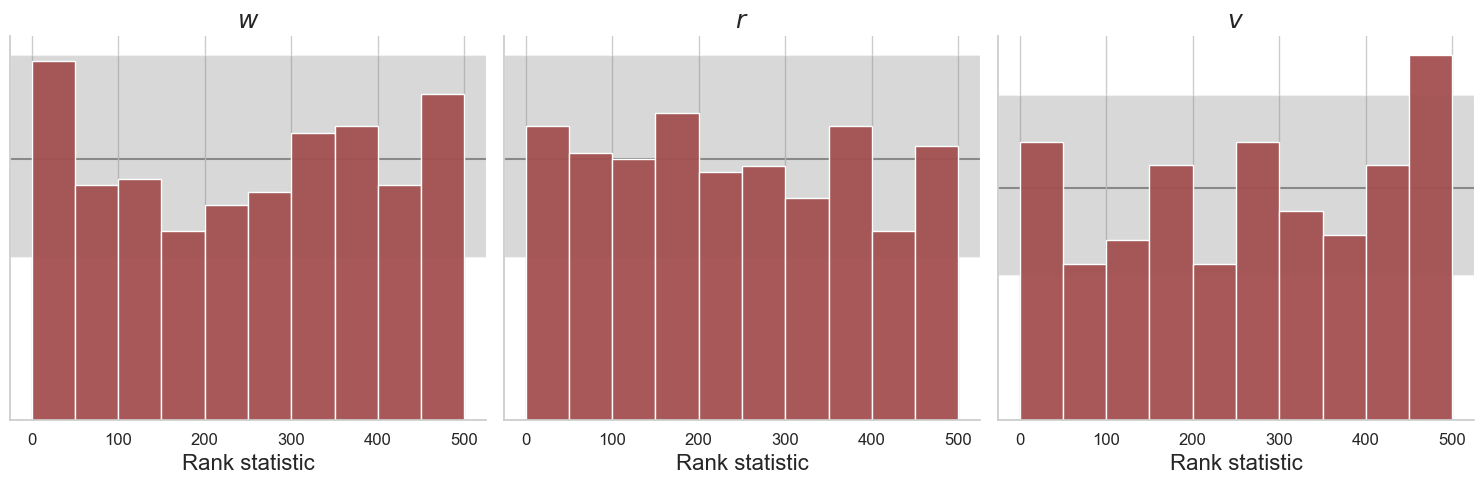

In [129]:
h = bf.diagnostics.plot_sbc_histograms(
    post_samples=post_dev_samples, 
    prior_samples=prior_dev_samples, 
    param_names=param_names, 
    num_bins=10
)

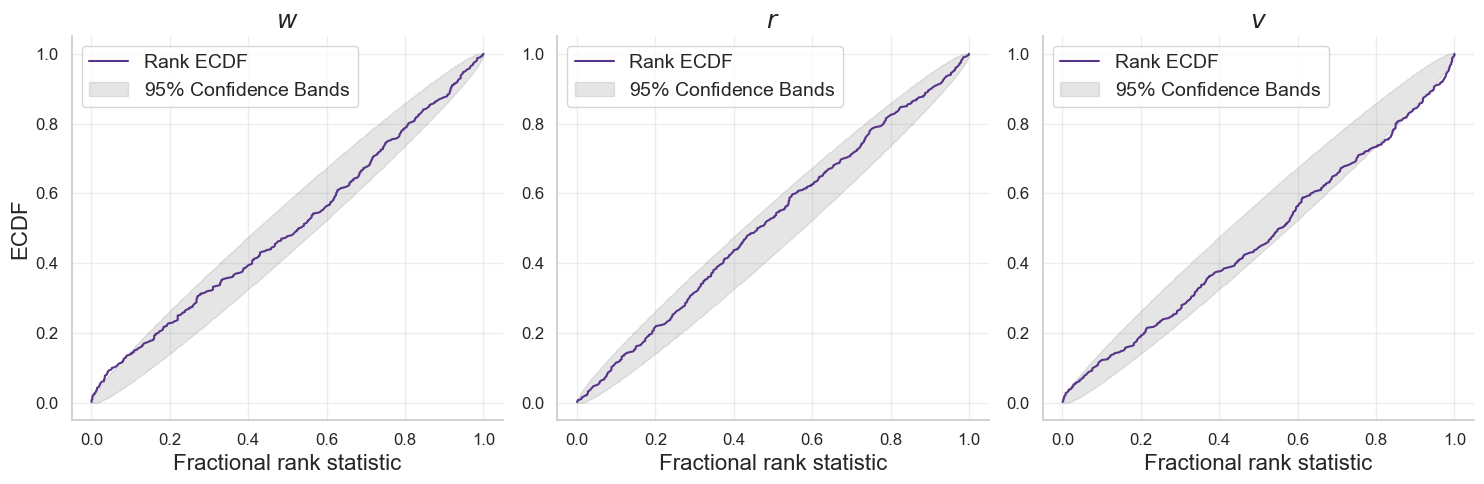

In [130]:
e = bf.diagnostics.plot_sbc_ecdf(
    post_samples=post_dev_samples, 
    prior_samples=prior_dev_samples, 
    param_names=param_names, 
    rank_ecdf_color="#4E2A84"
)

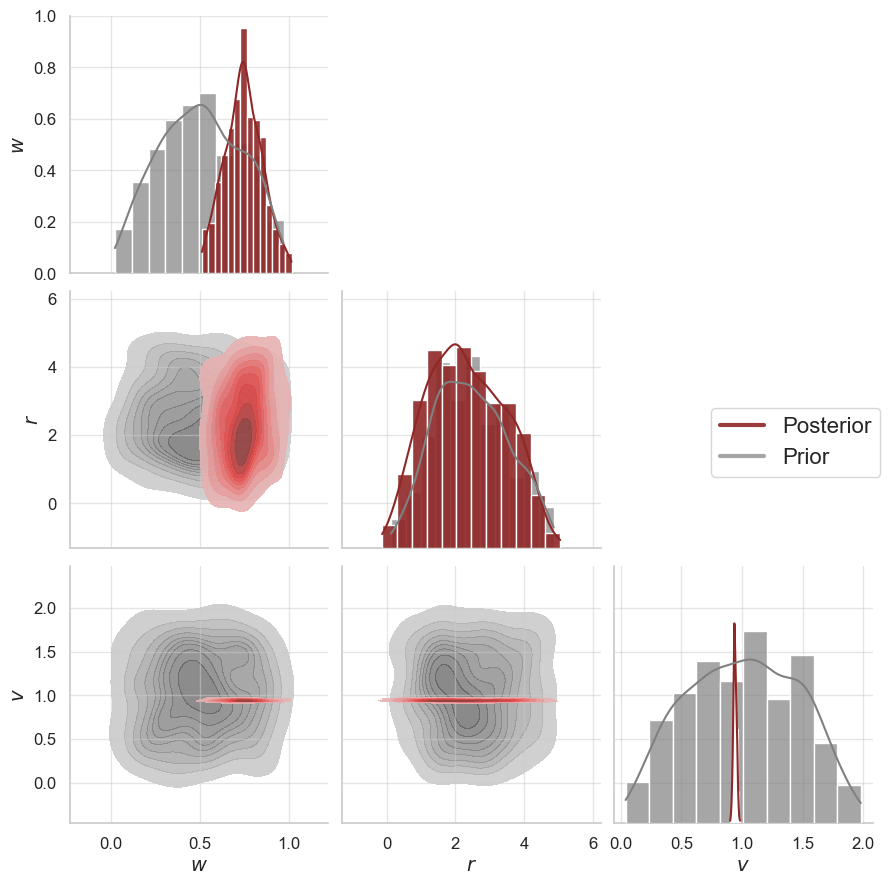

In [131]:
d = bf.diagnostics.plot_posterior_2d(
    posterior_draws=post_dev_samples[1], 
    prior_draws=prior_dev_samples, 
    param_names=param_names
)

### Online Training

Do this part (previous results come from training only 1 epoch and 200 iterations).

In [463]:
# Now it has changed to 300 epochs with 500 steps each (150000 total)
history = trainer.train_online(epochs=300, batch_size=32, iterations_per_epoch=500)

Training epoch 1:   0%|          | 0/200 [00:00<?, ?it/s]

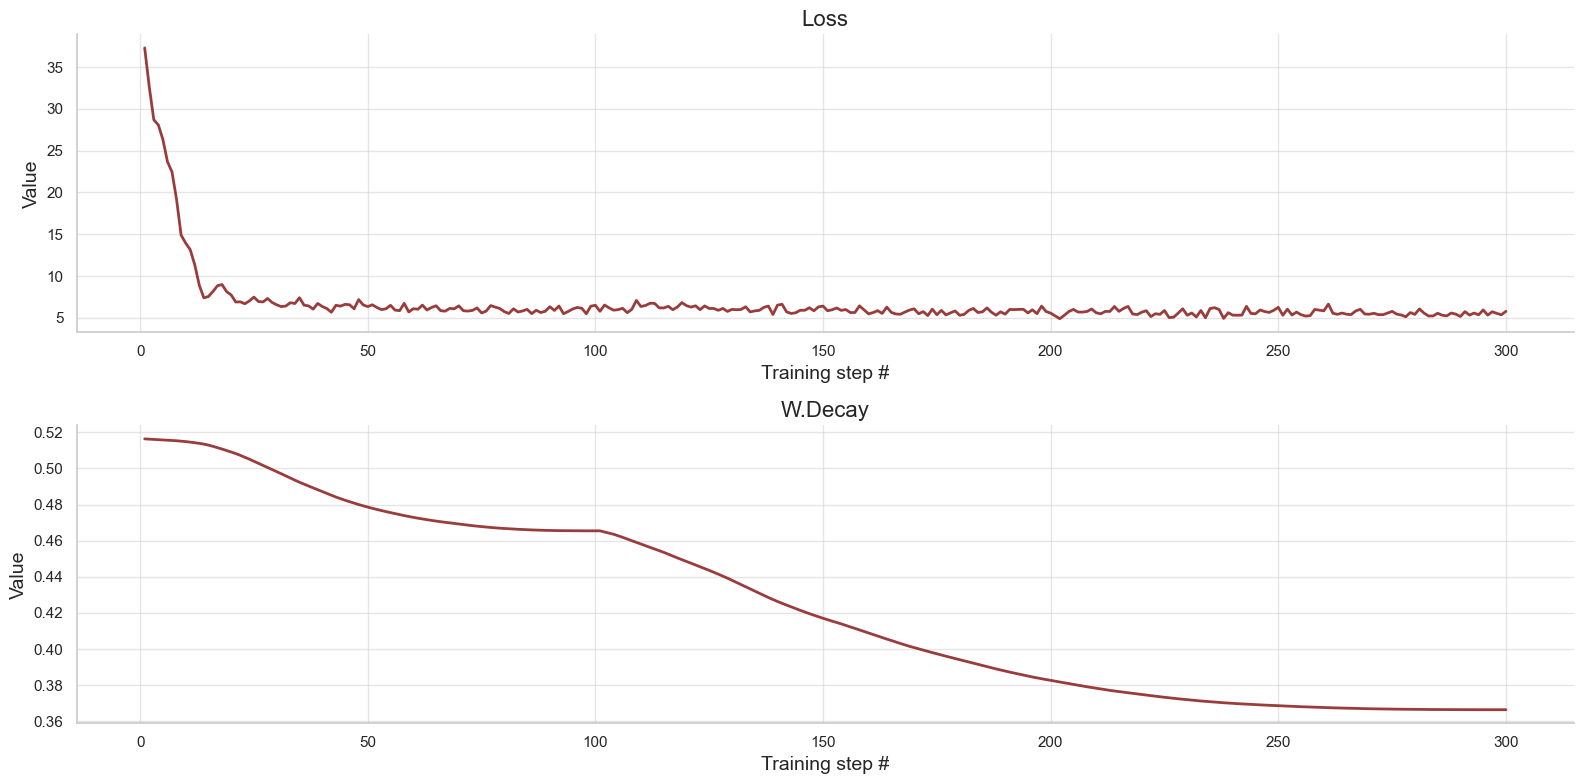

In [464]:
f = bf.diagnostics.plot_losses(history)

### Validation

In [465]:
validation_sim = model(400)
validation_configured = configurator(validation_sim)

In [466]:
validation_configured["parameters"]

array([[0.07457702, 2.2404974 , 0.32573527, 2.164974  , 4.5262146 ],
       [0.43720496, 0.82371724, 0.498905  , 3.9733164 , 4.486686  ],
       [0.19165172, 7.8879843 , 0.2869358 , 4.3568354 , 2.5753455 ],
       ...,
       [0.46955454, 2.6333323 , 0.6379486 , 2.6327906 , 5.824963  ],
       [0.44751653, 4.016421  , 0.37790635, 4.3941045 , 2.7543514 ],
       [0.16260357, 2.1308763 , 0.7748053 , 3.3457994 , 6.5417805 ]],
      dtype=float32)

In [467]:
post_samples = amortizer.sample(validation_configured, n_samples=1000)
prior_samples = validation_configured["parameters"]

# Parameter Recovery

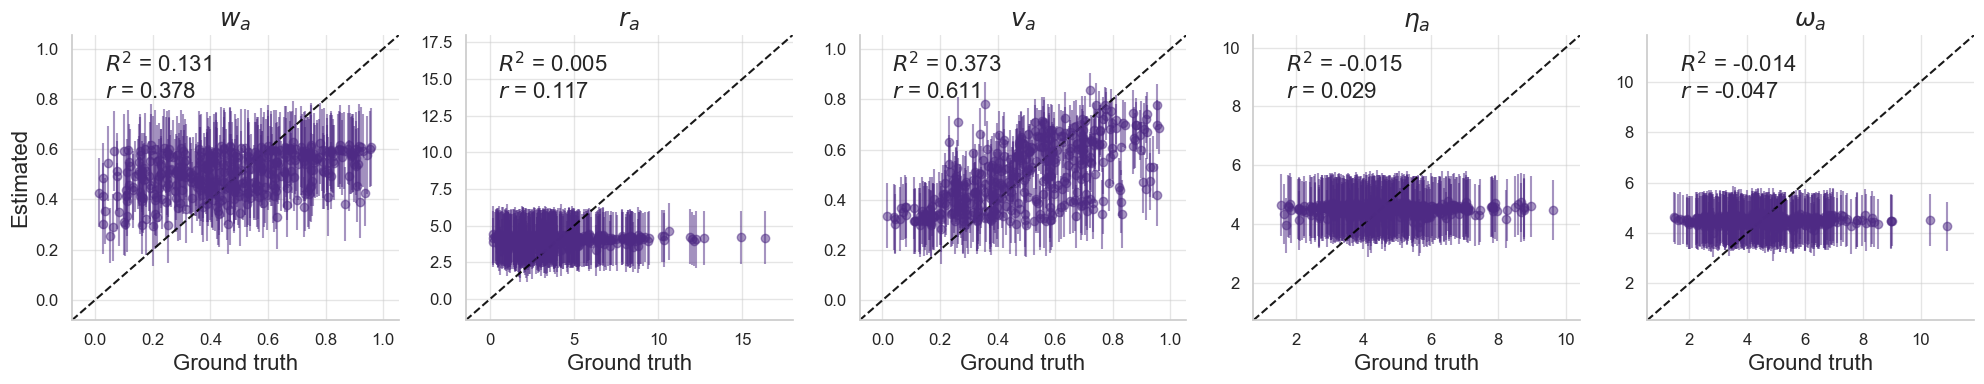

In [468]:
sns.set(rc={'axes.facecolor':'#FFFFFF00', 'figure.facecolor':'#FFFFFF00'})
sns.set_style('whitegrid')

g = bf.diagnostics.plot_recovery(
    post_samples=post_samples, 
    prior_samples=prior_samples, 
    param_names=param_names,
    color="#4E2A84"
)

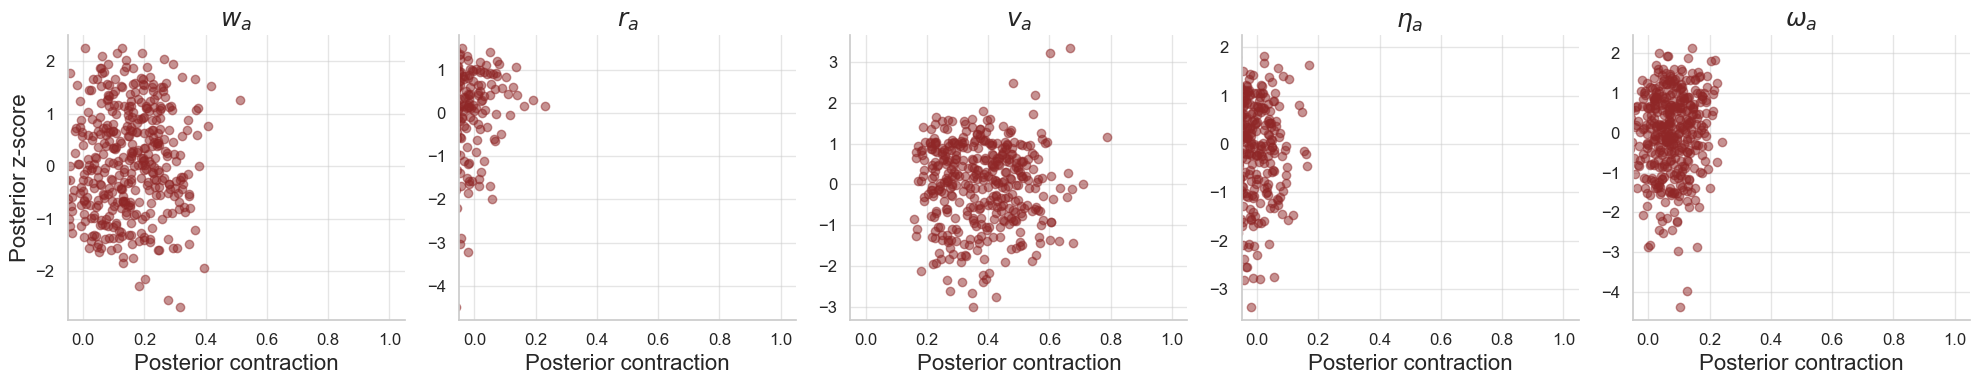

In [469]:
c = bf.diagnostics.plot_z_score_contraction(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names)

# SBC

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 0.                    Confidence intervals might be unreliable!


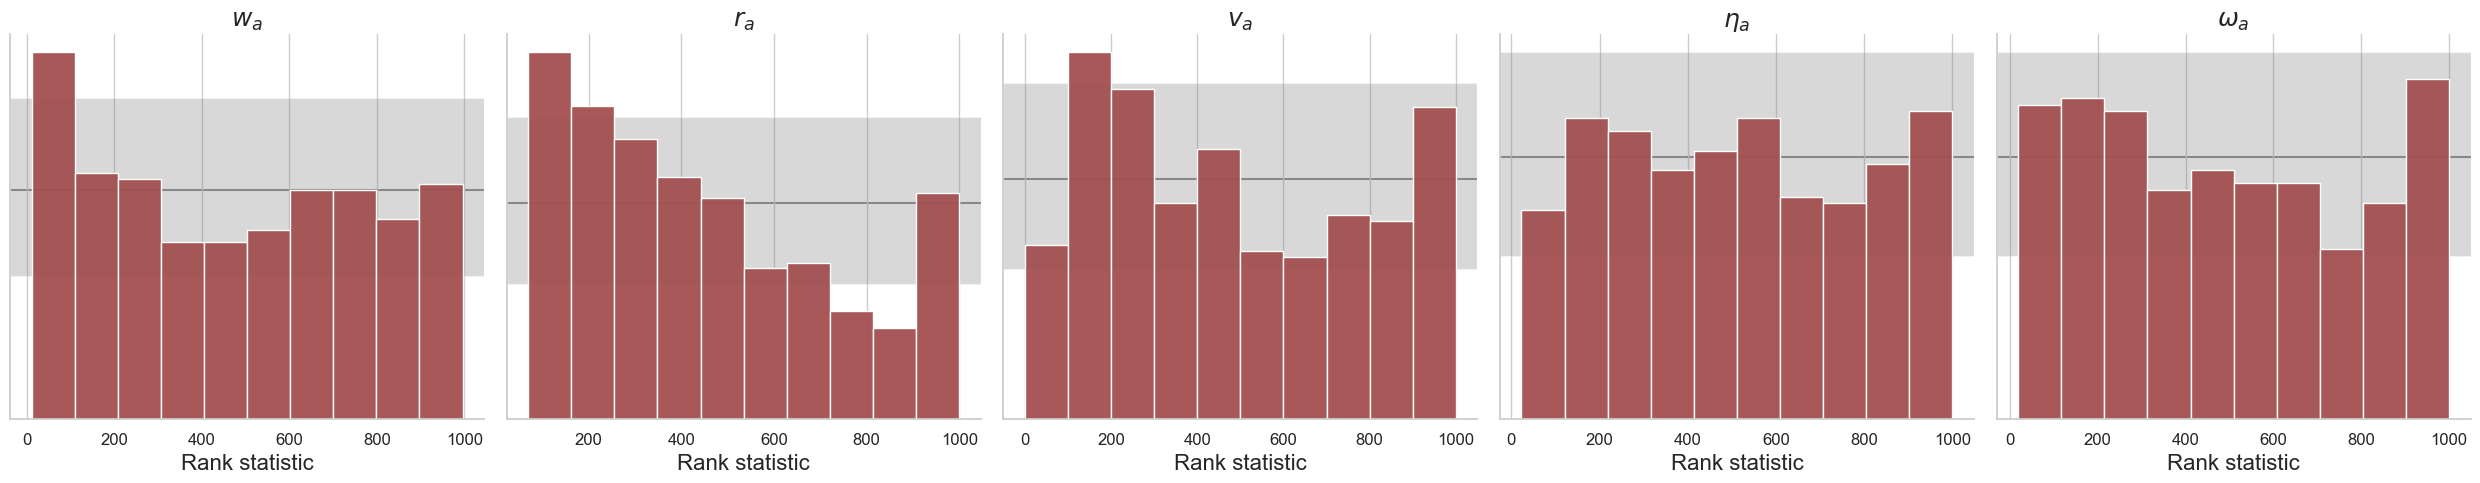

In [470]:
h = bf.diagnostics.plot_sbc_histograms(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names, num_bins=10, )

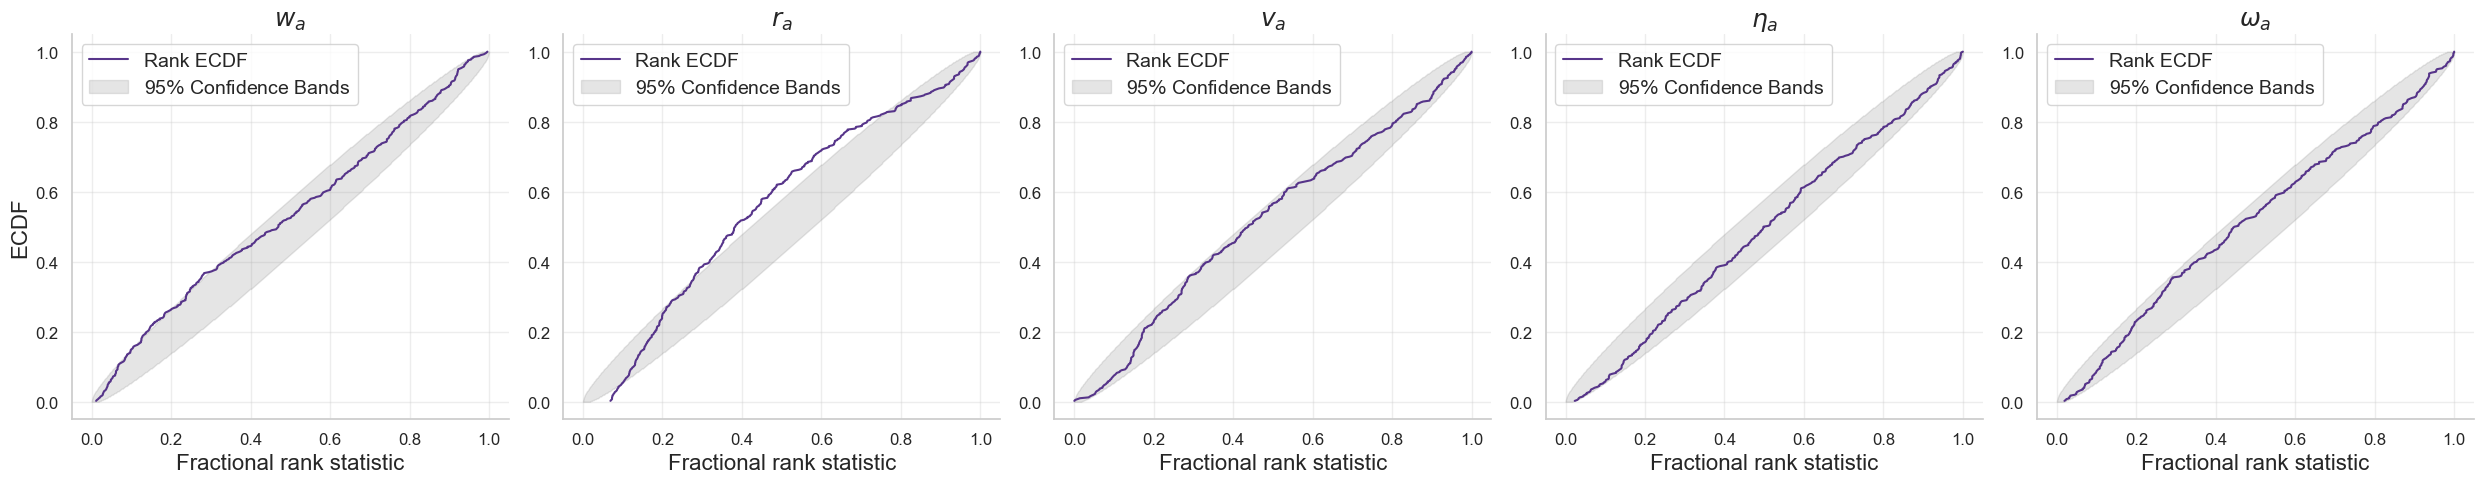

In [471]:
e = bf.diagnostics.plot_sbc_ecdf(
    post_samples=post_samples, 
    prior_samples=prior_samples, 
    param_names=param_names, 
    rank_ecdf_color="#4E2A84"
)

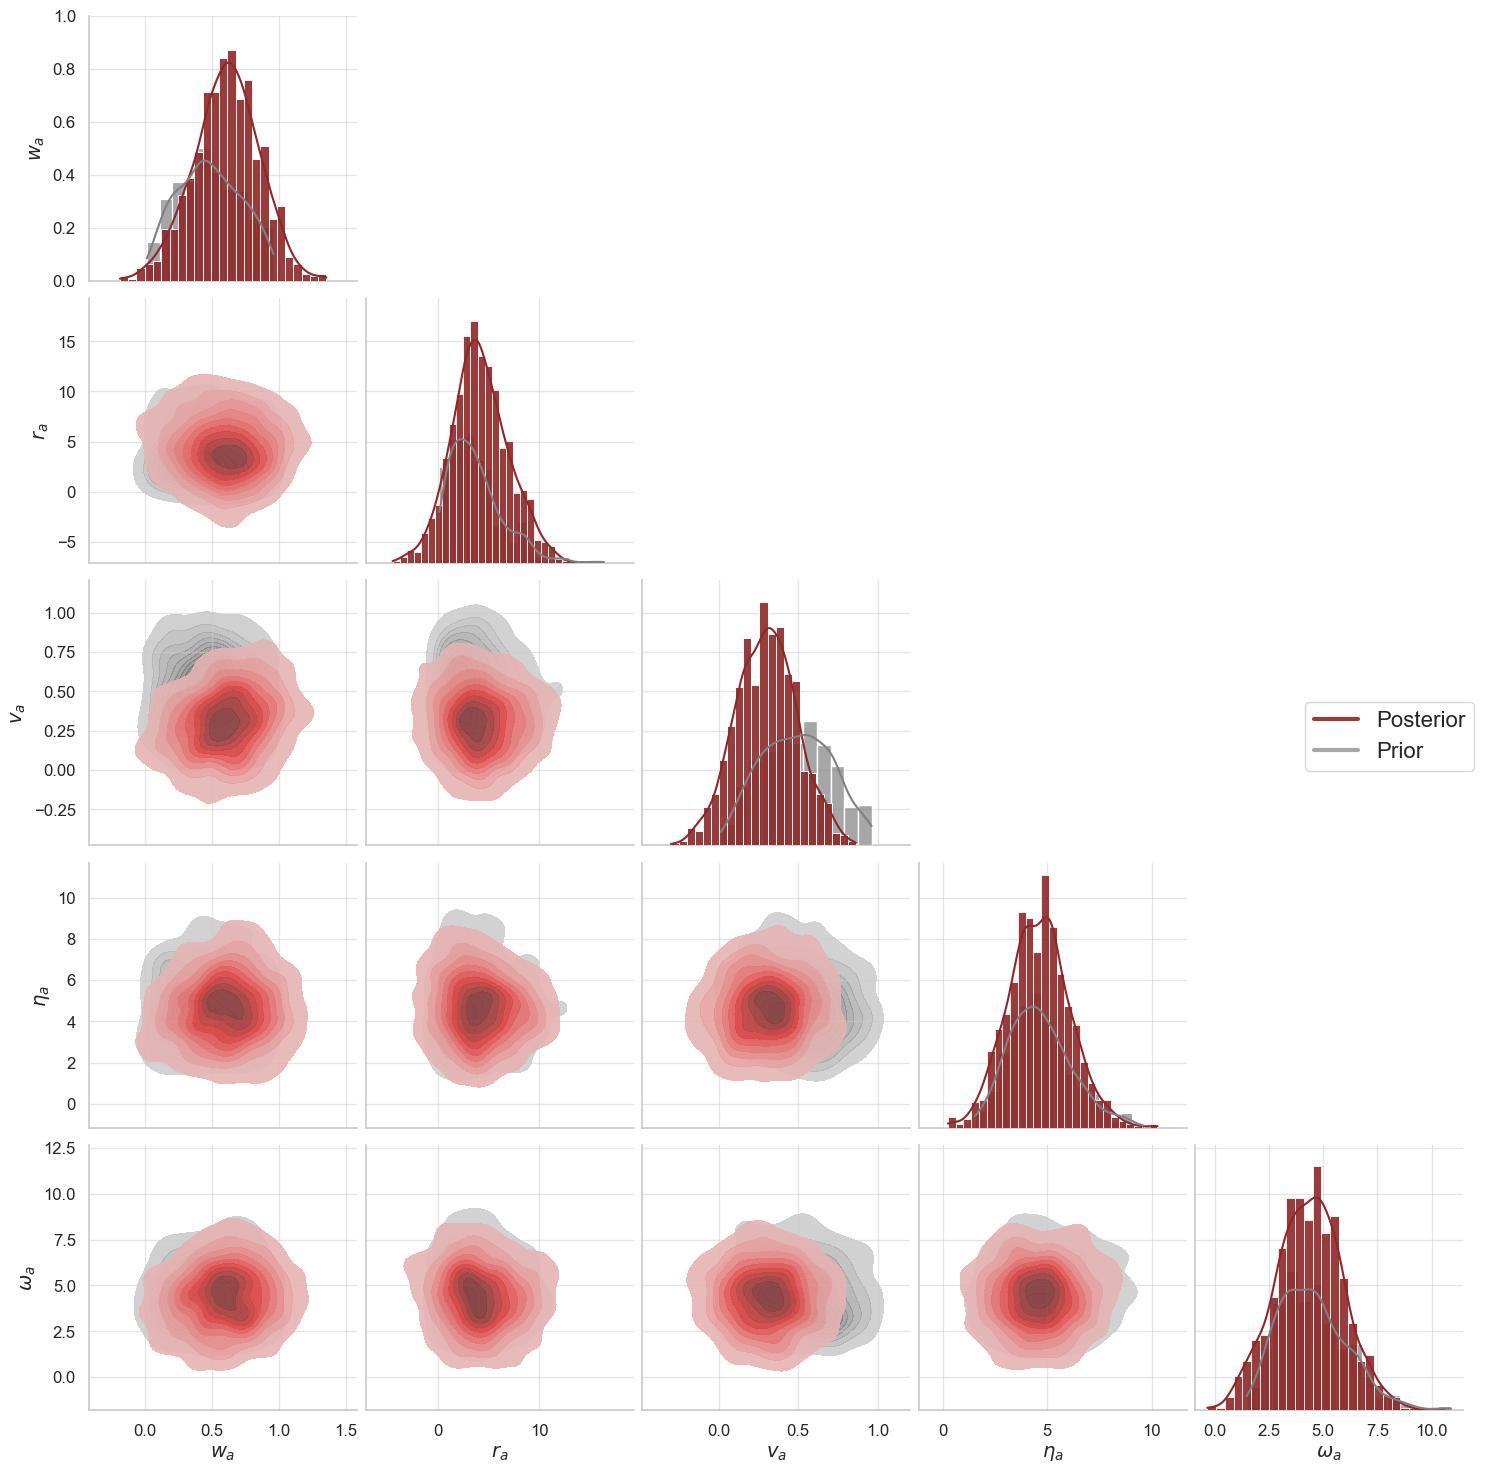

In [472]:
d = bf.diagnostics.plot_posterior_2d(posterior_draws=post_samples[1], prior_draws=prior_samples, param_names=param_names)